# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(defs)
    reload(params)
finally:
    os.chdir(nbPath)
    
print('Done')

Done


# reading data

In [2]:
rng = params.rng

def get_data_array2(data_list: list[pd.DataFrame], epoch=None , area: str ='M1', model=None, n_components:int = 10) -> np.ndarray:
    """Clone of `get_data_array` without enforcing same number of trials per target"""
    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]
    if model is None:
        model = PCA(n_components=n_components, svd_solver='full')
    elif isinstance(model, int):
        model = PCA(n_components=model, svd_solver='full')
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    for df in data_list:
        n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    if epoch is not None:
        df_ = pyal.restrict_to_interval(data_list[0],epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), 1, n_shared_trial, n_timepoints, model.n_components))

    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = model.fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        all_id = df_.trial_id.to_numpy()
        # to guarantee shuffled ids
        while ((all_id_sh := rng.permutation(all_id)) == all_id).all():
            continue
        all_id = all_id_sh
        # select the right number of trials to each target
        df_ = pyal.select_trials(df_, lambda trial: trial.trial_id in all_id[:n_shared_trial])
        for trial, trial_rates in enumerate(df_._pca):
            AllData[session,0,trial, :, :] = trial_rates

    return AllData

def get_data_array_and_vel2(data_list: list[pd.DataFrame], epoch , area: str ='M1', n_components: int =10) -> np.ndarray:
    """Clone of `get_data_array_and_vel` without enforcing same number of trials per target"""
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    for df in data_list:
        n_shared_trial = np.min((df.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    df_ = pyal.restrict_to_interval(df,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), 1, n_shared_trial, n_timepoints, n_components))
    AllVel  = np.empty((len(data_list), 1, n_shared_trial, n_timepoints, 3))
    
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        all_id = df_.trial_id.to_numpy()
        rng.shuffle(all_id)
        df_ = pyal.select_trials(df_, lambda trial: trial.trial_id in all_id[:n_shared_trial])
        for trial, (trial_rates,trial_vel) in enumerate(zip(df_._pca, df_.hVelB)):
            AllData[session,0,trial, :, :] = trial_rates
            AllVel[session,0,trial, :, :] = trial_vel
    
    return AllData, AllVel

def get_data_array_and_vel3(data_list: list[pd.DataFrame], epoch , area: str ='M1', n_components: int =10) -> np.ndarray:
    """Clone of `get_data_array_and_vel2` without enforcing same number of trials, ie flat output"""
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    for df in data_list:
        n_shared_trial = np.min((df.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    df_ = pyal.restrict_to_interval(df,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), n_shared_trial * n_timepoints, n_components))
    AllVel  = np.empty((len(data_list), n_shared_trial * n_timepoints, 3))
    
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        all_id = df_.trial_id.to_numpy()
        rng.shuffle(all_id)
        df_ = pyal.select_trials(df_, lambda trial: trial.trial_id in all_id[:n_shared_trial])
        AllData[session, :, :] = np.concatenate(df_._pca.values, axis=0)
        AllVel[session, :, :] = np.concatenate(df_.hVelB.values, axis=0)
        
    return AllData, AllVel

def add_history_to_data_array2(allData, n_hist):
    """
    """
    assert allData.ndim == 3, 'Wrong input size'
    newShape = list(allData.shape)
    newShape[-1] *= (n_hist+1)
    
    out = np.empty(newShape)
    for session,sessionData in enumerate(allData):
        out[session,:,:] = dt.add_history(sessionData, n_hist)
    return out


In [3]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)
    
clear_output()

# Decoding

Decode the arm velocity from M1 and Str activity.

## Within animal, within session

Same as *"within-day"* analysis of the NN paper

### M1

In [8]:
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_pull_off',
                                     rel_start=int(-.5/defs.BIN_SIZE),
                                     rel_end=int(-.035/defs.BIN_SIZE)
                                    )
# exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
#                                      rel_start=int(-.05/defs.BIN_SIZE),
#                                      rel_end=int(.45/defs.BIN_SIZE)
#                                     )

from tensorflow import keras 
keras_v1=int(keras.__version__[0])<=1
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Activation, Dropout
from keras.utils import np_utils
from Neural_Decoding.decoders import LSTMDecoder

ModuleNotFoundError: No module named 'keras'

In [6]:
reg_scores = []

for i, df in enumerate(AllDFs):
    AllData, AllVel = get_data_array_and_vel3([df], exec_epoch, area=defs.areas[0], n_components=defs.n_components)
    # adding history
    AllData = add_history_to_data_array2(AllData,defs.MAX_HISTORY)
    
#     _,_,n_trial,n_time,n_comp = AllData.shape
#     trialId = np.arange(n_trial)
#     params.rng.shuffle(trialId)  # shuffle the trial order
#     half_trials = int(n_trial /1)
#     AllData1 = AllData[0,...][:,trialId[:half_trials], :,:]
#     AllData2 = AllData[0,...][:,trialId[-half_trials:],:,:]
#     AllVel1 = AllVel[0,...][:,trialId[:half_trials], :,:]
#     AllVel2 = AllVel[0,...][:,trialId[-half_trials:],:,:]

    _,n_time,n_comp = AllData.shape
    half_trials = int(n_time / 1)
    AllData1 = AllData[0,...][:half_trials, :]
    AllData2 = AllData[0,...][-half_trials:,:]
    AllVel1 = AllVel[0,...][:half_trials,:]
    AllVel2 = AllVel[0,...][-half_trials:,:]

    # resizing
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,3))
    AllVel1 = AllVel1.reshape((-1,3))
    #remove NaNs from the data 
    nanIndex = np.isnan(AllVel1.T).nonzero()[1]
    nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
    goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
    print(f'timepoints removed = {len(np.unique(nanIndex))/len(X1)*100:2.1f}%')

    *_,U,V = dt.canoncorr(X1[goodIndex,:], X2[goodIndex,:], fullReturn=True)
    # train the decoder
    reg_x = LSTMDecoder()
    reg_y = LSTMDecoder()
    reg_z = LSTMDecoder()
    Y_train_x,Y_train_y, Y_train_z = AllVel1.T[:,goodIndex]
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    reg_z.fit(U, Y_train_z)
    # test the decoder
    Y_test_x,Y_test_y, Y_test_z = AllVel2.T[:,goodIndex]
    x_score = defs.custom_r2_func(Y_test_x,reg_x.predict(V))
    y_score = defs.custom_r2_func(Y_test_y,reg_y.predict(V))
    z_score = defs.custom_r2_func(Y_test_z,reg_z.predict(V))
#     print(f'cross-validated score: {cross_val_score(LinearRegression(),V,Y_test_x,scoring=defs.custom_r2_scorer, cv=10).mean():.2f}\n')

    reg_scores.append((i,(x_score,y_score,z_score)))

pop_score_day = []
for _,scores in reg_scores:
    pop_score_day.append(np.mean(scores))
pop_score_day = np.array(pop_score_day)

timepoints removed = 0.0%


NameError: name 'Sequential' is not defined

Text(0.5, 1.0, 'Velocity Decoding --- within session')

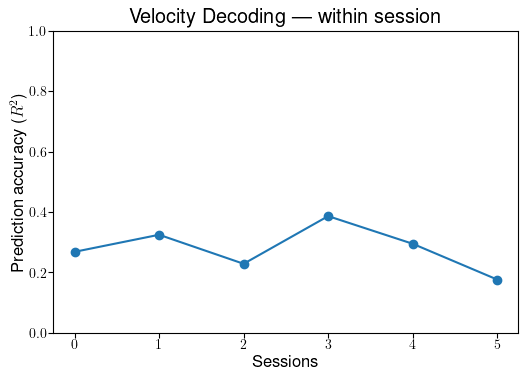

In [205]:
_,ax = plt.subplots(dpi=100)
ax.plot(pop_score_day,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Sessions')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding --- within session')

Now... Same as above, for different animals

# Across animal decoding

## With alignment 

In [13]:
pairIndex_across = []
for i, df1 in enumerate(AllDFs):
    pairIndex_across.append((i,[]))
    for j, df2 in enumerate(AllDFs):
        if df1.mouse[0] == df2.mouse[0]: continue
        pairIndex_across[-1][1].append(j)
pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

In [ ]:
warnings.filterwarnings("ignore")
reg_scores_across = []
for id1, testId in pairIndex_across:
    AllData, AllVel = get_data_array_and_vel2([AllDFs[id1],AllDFs[testId]], defs.exec_epoch, area=defs.areas[0], n_components=defs.n_components)
    
    # adding history
    AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = custom_r2_func(Y_test_y, reg_y.predict(V))
    reg_scores_across.append((id1,testId,(x_score,y_score)))
warnings.filterwarnings("default")

pop_score_across = []
for _,_,scores in reg_scores_across:
    pop_score_across.append(np.mean(scores))
pop_score_across = np.array(pop_score_across)

normalised_across_score = []
for idx1, idx2, scores in reg_scores_across:
    across_score = np.add(*scores)/2
    animal_avg = np.mean([*animal_scores[full_list[idx1][0]], *animal_scores[full_list[idx2][0]]])
    normalised_across_score.append(across_score/animal_avg)
normalised_across_score = np.array(normalised_across_score)

In [ ]:
_,ax = plt.subplots()
ax.plot(pop_score_across,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding --- across animals')

In [ ]:
_,ax = plt.subplots()
ax.plot(normalised_across_score,'-o')
# ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel(r'Normalised prediction accuracy')
ax.set_title(r'Velocity Decoding: $\frac{R^2_{across}}{max(R^2_{within})}$', pad = 15)

## Without alignment

In [ ]:
warnings.filterwarnings("ignore")
reg_latent_scores = []
for id1, testId in pairIndex_across:
    AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)

    # adding history
    AllData = dt.add_history_to_data_array(AllData,MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
#     *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(X1, Y_train_x)
    reg_y.fit(X1, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = custom_r2_func(Y_test_x, reg_x.predict(X2))
    y_score = custom_r2_func(Y_test_y, reg_y.predict(X2))
    reg_latent_scores.append((id1,testId,(x_score,y_score)))
warnings.filterwarnings("default")

pop_latent_score = []
for _,_,scores in reg_latent_scores:
    pop_latent_score.append(np.mean(scores))
pop_latent_score = np.array(pop_latent_score)

normalised_latent_score = []
for idx1, idx2, scores in reg_latent_scores:
    across_score = np.add(*scores)/2
    animal_avg = np.mean([*animal_scores[full_list[idx1][0]], *animal_scores[full_list[idx2][0]]])
    normalised_latent_score.append(across_score/animal_avg)
normalised_latent_score = np.array(normalised_latent_score)

In [ ]:
_,ax = plt.subplots()
ax.plot(pop_latent_score,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding --- across animals without alignment')

# Universal Decoder

In [ ]:
%run "_M1-universal-decoding.ipynb"

# histograms

In [ ]:
fig,ax = plt.subplots(dpi=100)

bins = np.arange(0,1,0.05)
ax.hist(pop_score_across, bins=bins, density=True, label=r'Across monkey (\textit{aligned})', alpha=.8)
# ax.hist(pop_score2, bins=bins, density=True, label='aligned across days', alpha=.8)
ax.hist(pop_score_uni, bins=bins, density=True, label='Universal', alpha=.8)
ax.hist(pop_score_day, bins=bins, density=True, label='Within monkey', alpha=.8)
ax.hist(pop_latent_score, bins=bins, density=True, label=r'Across monkey (\textit{unaligned})', alpha=.8)

ax.set_title('Decoding velocity --- M1')
ax.set_xlabel('Prediction accuracy ($R^2$)')
ax.set_ylabel(r'Normalised \# of sessions')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([-.05,1])
ax.legend(loc=(.2,.7))